# What Noise Should I Choose?

## Introduction

Thus far, we've been using `.noise()` to make our queries differentially private. However, there are different types of noise available including Laplacian noise and Gaussian noise. In this notebook, we will describe how the two noise distributions differ and how you can choose one which is most appropriate for your particular analysis. 

The default `.noise()` method chooses one of these distributions for you based on the limited information you've provided, specifically the privacy measure. If the privacy measure requires pure-DP to be satisfied, then the Laplace distribution will be used for noise. Otherwise, the Gaussian distribution may be used to satisfy zero concentrated DP. However, with a better understanding of both distributions, you can specify the type of noise and its parameters for higher utility!

In [1]:
import polars as pl 
import opendp.prelude as dp
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np 

dp.enable_features("contrib")
sns.set_theme(style='darkgrid')

## Laplace vs. Gaussian

The Laplace and Gaussian distributions are the two primary mechanisms to add noise to ensure differential privacy and preserve relationships for statistical analysis. The two distributions may appear similar at first glance, but there are key differences in their use in differential privacy techniques. 

**1. Definition of Privacy:**
 Differential privacy mechanisms using the Laplace distribution satisfy the pure ε-dp, whereas differentially private outputs using the Gaussian mechanism satisfy a more relaxed definition of differential privacy, approximate DP. Therefore, Laplace provides more precise privacy guarantees.

**2. Accuracy:**
Differentially private outputs using the Gaussian mechanism can be further from the true answer compared to outputs using the Laplace mechanism, depending on the context. 

This is supported by the following plot which graphs the empirical probability density function of the Laplace and Gaussian mechanisms with ε = 1 and δ = 10^-5. 


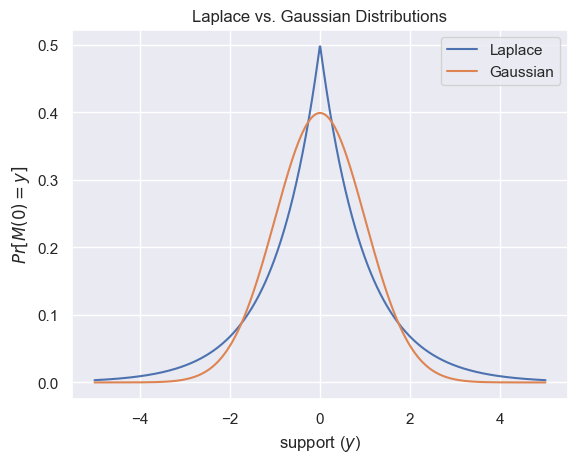

In [2]:
def laplace_pdf(b, mu=0):
    return lambda x: np.exp(-abs(x - mu) / b) / (2 * b)

def gaussian_pdf(b, mu=0):
    return lambda x: np.exp(-((x - mu) / b) ** 2 / 2) / (np.sqrt(2 * np.pi) * b)


scale = 1.
cont_support = np.linspace(-5, 5, num=1000)
plt.plot(cont_support, laplace_pdf(scale)(cont_support), label="Laplace")
plt.plot(cont_support, gaussian_pdf(scale)(cont_support), label="Gaussian")
plt.xlabel("support ($y$)")
plt.ylabel("$Pr[M(0) = y]$")
plt.title("Laplace vs. Gaussian Distributions")
plt.legend()
plt.show()

**3. Type of Output:**

Gaussian mechanisms perform better than Laplace mechanisms particularly when 

*1. The L2 sensitivity is smaller than the L1 sensitivity.* 

The Laplace mechanism requires the use of the L1 norm (sum of absolute values) and results in a sensitivity of k (length of output vector). The Gaussian mechanism allows the use of the L1 norm or the L2 norm (Euclidean distance). With the Gaussian mechanism and L2 norm, the sensitivity can be $\sqrt{k}$. In such cases, the L2 sensitivity is significantly lower than the L1 sensitivity. Therefore, the Gaussian mechanism allows for less noise to be added and results in higher utility. 

This is particularly applicable when working with vectors. 

To learn more about the methodology behind the sensitivity calculation, see [chapter 6 in _Programming DP_](https://programming-dp.com/ch6.html).

*2. There are many compositions.* 

As illustrated by the diagram, the Gaussian distribution has lighter tails. In cases with many compositions, many queries are run with independent noise. Adding more compositions leads to more dimensions to calculate the sensitivity, which leads to the case where the L2 sensitivity is likely less than the L1 sensitivity. 

#### When To Use:
| Laplace Noise | Gaussian Noise |
|-------------------|--------------------|
| When you need strong privacy guarantees (ε-DP). | When working with high-dimensional data or vectors. |
| For applications involving single numerical outputs or low-dimensional data. | For machine learning models that return outputs with many elements or complex applications that result in multidimensional data. |
| When the noise added should be minimal and accuracy is crucial. | When the L2 norm (Euclidean distance) is smaller than the L1 norm (sum of absolute values). |
| Statistical queries such as counts, sums, and averages. | When a small relaxation in privacy guarantees, i.e. (ε, δ)-DP, is acceptable in exchange for reduced noise. |

### Summary

- **Laplace Noise**: Best for single-value outputs and applications requiring strong privacy guarantees.
- **Gaussian Noise**: Best for high-dimensional data and applications where a small relaxation in privacy is acceptable for reduced noise and better utility.

By understanding the nature of your data and the requirements of your application, you can choose the appropriate noise mechanism to ensure both privacy and accuracy.


## Specifying Laplace or Gaussian with the Context API

Let's get into how you could specify which type of noise you may need. The process is relatively similar to using the generic `noise()` method. The difference is that you'll specify your noise and provide the appropriate parameters. 

In [3]:
df = pl.scan_csv(dp.examples.get_france_lfs_path(), ignore_errors=True)

context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(epsilon=1.0),
    split_evenly_over=10,
    margins=[
        dp.polars.Margin(max_length=60_000_000),
        dp.polars.Margin(by=["ILOSTAT"], invariant="keys"),
    ],
)

Compute the count of people by their labor status. First, compute the actual statistics. 

See the [EU LFS User Guide](https://ec.europa.eu/eurostat/documents/1978984/6037342/EULFS-Database-UserGuide.pdf) for labor status codes. 

In [4]:
labor_status_codes = {
    9: "NA",
    2: "Not Working But Employed",
    1: "Working for Pay",
    3: "Laid Off",
}

actual_values = df.group_by("ILOSTAT").agg(pl.len().alias("Actual")).collect()

actual_values = actual_values.with_columns(
    pl.col("ILOSTAT").map_elements(lambda x: labor_status_codes.get(x, x))
)

actual_values

/var/folders/jm/40wztt291610f8pk5w0sw20r0000gq/T/ipykernel_49512/3463634038.py:10: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  actual_values = actual_values.with_columns(


ILOSTAT,Actual
str,u32
"""Not Working But Employed""",155661
"""Laid Off""",1450283
"""Working for Pay""",1517011
"""NA""",688977


Remember that using Laplacian noise takes in one parameter, `epsilon`, so when using Laplacian noise, we don't need to define the context any differently than before.

In [5]:
laplace_values = (
    context.query()
    .group_by("ILOSTAT")
    .agg(pl.len().dp.laplace().alias("Laplace Noise"))
    .release()
    .collect()
)

laplace_values = laplace_values.with_columns(
    pl.col("ILOSTAT").map_elements(lambda x: labor_status_codes.get(x, x))
)

laplace_values

/var/folders/jm/40wztt291610f8pk5w0sw20r0000gq/T/ipykernel_49512/507398228.py:9: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  laplace_values = laplace_values.with_columns(


ILOSTAT,Laplace Noise
str,u32
"""Not Working But Employed""",155548
"""Working for Pay""",1516482
"""Laid Off""",1449716
"""NA""",689055


To use the Gaussian mechanism for adding noise, we specify a different parameter, `rho`, instead of `epsilon`; `rho` is set to 0.5 for this tutorial.

In [6]:
context = dp.Context.compositor(
    data=df,
    privacy_unit=dp.unit_of(contributions=36),
    privacy_loss=dp.loss_of(rho=0.5),
    split_evenly_over=10,
    margins=[
        dp.polars.Margin(max_length=150_000 * 36),
        dp.polars.Margin(by=["ILOSTAT"], invariant="keys"),
    ],
)

gaussian_values = (
    context.query()
    .group_by("ILOSTAT")
    .agg(pl.len().dp.gaussian().alias("Gaussian Noise"))
    .release()
    .collect()
)

gaussian_values = gaussian_values.with_columns(
    pl.col("ILOSTAT").map_elements(lambda x: labor_status_codes.get(x, x))
)

gaussian_values

/var/folders/jm/40wztt291610f8pk5w0sw20r0000gq/T/ipykernel_49512/4111148899.py:20: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  gaussian_values = gaussian_values.with_columns(


ILOSTAT,Gaussian Noise
str,u32
"""Laid Off""",1450379
"""Working for Pay""",1517060
"""NA""",688807
"""Not Working But Employed""",155593


## Comparing Results

In [7]:
noise_values = laplace_values.join(gaussian_values, on=["ILOSTAT"])

all_values = actual_values.join(noise_values, on=["ILOSTAT"])
all_values

ILOSTAT,Actual,Laplace Noise,Gaussian Noise
str,u32,u32,u32
"""Laid Off""",1450283,1449716,1450379
"""Working for Pay""",1517011,1516482,1517060
"""NA""",688977,689055,688807
"""Not Working But Employed""",155661,155548,155593


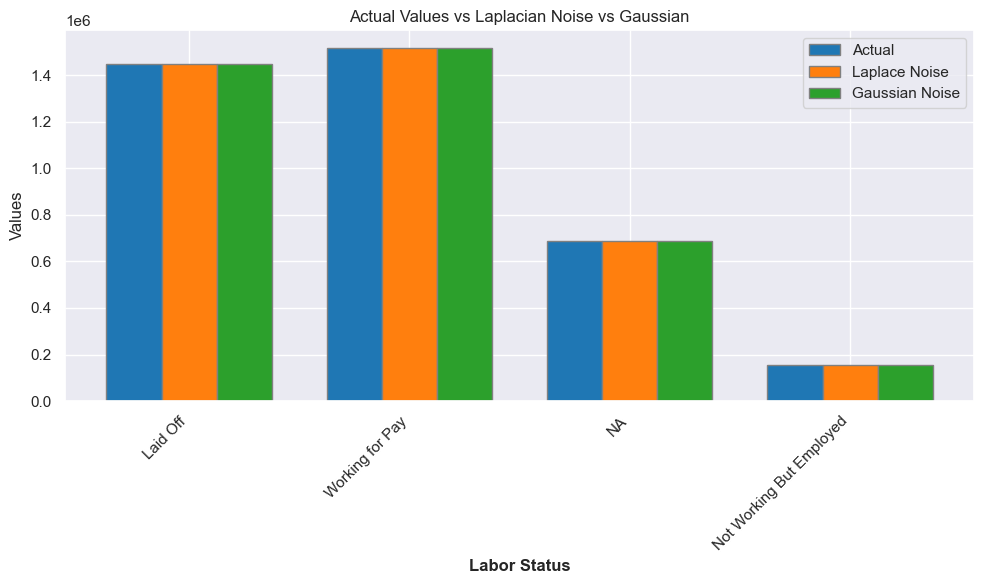

In [8]:
df = pl.DataFrame(all_values)
bar_width = 0.25
r1 = range(len(df["ILOSTAT"].to_list()))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart.
plt.figure(figsize=(10, 6))
plt.bar(r1, df["Actual"].to_list(), color='tab:blue', width=bar_width, edgecolor='grey', label='Actual')
plt.bar(r2, df["Laplace Noise"].to_list(), color='tab:orange', width=bar_width, edgecolor='grey', label='Laplace Noise')
plt.bar(r3, df["Gaussian Noise"].to_list(), color='tab:green', width=bar_width, edgecolor='grey', label='Gaussian Noise')

plt.xlabel('Labor Status', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(df["ILOSTAT"].to_list()))], df["ILOSTAT"].to_list(), rotation=45, ha='right')
plt.ylabel('Values')
plt.title('Actual Values vs Laplacian Noise vs Gaussian')

plt.legend()
plt.tight_layout()
plt.show()

Our differentially private outputs are quite accurate compared to the actual values. In this example the outputs using Laplacian and Gaussian noise do not differ significantly. This won't always be the case, and as you begin to apply differential privacy to more specialized applications, specifying the type of noise you want to add may increase utility.

## Conclusion

In this notebook, we accomplished the following objectives: 
- Understand the common differences between using Laplacian noise and Gaussian Noise. 
- Understand which applications may be better suited for Laplacian noise or Gaussian Noise. 
- Demonstrate how to specify the type of noise in the Context API.  